Run Explanation

In [53]:
# Compute explainer for each person in the dataset
import os
import torch
import torch_geometric
from torch_geometric.explain import GNNExplainer, Explainer
from train import Proteo
from proteo.datasets.ftd import FTDDataset
from models.gat_v4 import GATv4
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import train as proteo_train
import pandas as pd
import numpy as np
from proteo.datasets.ftd import MODALITY_COL_END


def load_config(module):
    '''Load the config from the module  and return it'''
    config = module.config
    return config

#Load model checkpoint - Note when the wrapper class is not necessary you can use this function from checkpoint_analysis.py
def load_checkpoint(relative_checkpoint_path):
    '''Load the checkpoint as a module. Note levels_up depends on the directory structure of the ray_results folder'''
    # Construct the full path to the checkpoint
    checkpoint_path = os.path.join(relative_checkpoint_path, 'checkpoint.ckpt')
    print("checkpoint_path", checkpoint_path)

    # Check if the file exists to avoid errors
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")
    
    module = proteo_train.Proteo.load_from_checkpoint(checkpoint_path)

    original_forward = module.model.forward
    # Redefine the forward method of module.model to return only pred
    def new_forward(self, x, edge_index=None, data=None):
        pred, _ = original_forward(x, edge_index, data)
        return pred
    
    module.model.forward = new_forward.__get__(module.model)
    return module

module = load_checkpoint('/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-08-01_10-30-17/model=gat-v4,seed=3784_347_act=elu,adj_thresh=0.0500,batch_size=8,dropout=0.1000,l1_lambda=0.0010,lr=0.0007,lr_scheduler=CosineAnn_2024-08-01_11-17-45/checkpoint_000101')
config = load_config(module)

# Load datasets
train_dataset, test_dataset = proteo_train.construct_datasets(config)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Choose dataset
dataset = train_dataset
dataset.to(device)

#Load protein ids
# Define the path to the CSV file
CSV_PATH = "/home/data/data_louisa/raw/ALLFTD_dataset_for_nina_louisa_071124.csv"
def get_protein_ids(config):
        print("Loading data from:", CSV_PATH)
        csv_data = pd.read_csv(CSV_PATH)

        # Extract the protein column names
        modality_cols = [
            col
            for col in csv_data.columns
            if col.endswith(MODALITY_COL_END[config.modality])
        ]
        
        return np.array(modality_cols)

protein_ids = get_protein_ids(config)
print(len(protein_ids))


# Construct Explainer and set parameters
explainer = Explainer(
model=module.model.to(device),
algorithm=GNNExplainer(),
explanation_type='model',
model_config=dict(
    mode='regression',
    task_level='graph',  # Explain why the model predicts a certain property or label for the entire graph (nodes + edges)
    return_type='raw'
),
node_mask_type='object', # Generate masks that indicate the importance of individual node features
edge_mask_type=None,
threshold_config=dict( #keep only the top 300 most important proteins and set the rest to 0
    threshold_type='topk',
    value=300,
),
)



# Run explainer on each person in dataset
i = 0 
all_proteins = []
print(len(dataset))
n_nodes = len(dataset[0].x)
print(f"n_nodes = {n_nodes}")
# Initialize sum_node_importance as a dictionary with protein_ids as keys
sum_node_importance = {protein_id: 0 for protein_id in protein_ids}

for data in dataset:
    data_attributes = data.keys
    # Ensure data.x and data.edge_index are tensors
    if not isinstance(data.x, torch.Tensor) or not isinstance(data.edge_index, torch.Tensor):
        raise TypeError("data.x and data.edge_index must be torch.Tensor")
    #print(f'Batch actual attributes: {data_attributes}')
    explanation = explainer(
        data.x,
        data.edge_index,
        data=data,
        target=None,
        index=None
    )
    #print(f'Generated explanations in {explanation.available_explanations}')
    # Node_importance is of format [[0], [0],[0],...,[.5]] with length equal to the number of nodes
    node_importance = explanation.node_mask.cpu().detach().numpy()
    if i <= n_nodes:
        #Note: this is not going to show the same proteins, it will just show the top 300 for 10 first people
        plt.plot(sorted(node_importance, reverse=True)[:300])

    # Find row indices of non-zero elements in node_importance
    indv_important_proteins_indices = np.nonzero(node_importance)[0]
    indv_important_proteins = protein_ids[indv_important_proteins_indices]
    
    all_proteins.append(indv_important_proteins) #array holding all the important proteins for each person

    # Update sum_node_importance dictionary using protein_ids as keys
    for idx, importance in enumerate(node_importance):
        protein_id = protein_ids[idx]
        sum_node_importance[protein_id] += importance[0]
        
    i += 1

print("Number of patients", i)
# Flatten the list of lists into a single list
full_count = [item for sublist in all_proteins for item in sublist]

# Use Counter to count the occurrences of each element
protein_count = Counter(full_count)
print(protein_count)
print(len(protein_count))


checkpoint_path /scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-08-01_10-30-17/model=gat-v4,seed=3784_347_act=elu,adj_thresh=0.0500,batch_size=8,dropout=0.1000,l1_lambda=0.0010,lr=0.0007,lr_scheduler=CosineAnn_2024-08-01_11-17-45/checkpoint_000101/checkpoint.ckpt
Loading data from: /home/data/data_louisa/processed/ftd_y_val_nfl_adj_thresh_0.05_num_nodes_150_mutation_C9orf72_csf_sex_M_train.pt
Loading data from: /home/data/data_louisa/processed/ftd_y_val_nfl_adj_thresh_0.05_num_nodes_150_mutation_C9orf72_csf_sex_M_test.pt
Loading data from: /home/data/data_louisa/raw/ALLFTD_dataset_for_nina_louisa_071124.csv
7289
18
n_nodes = 150


Plot Average Importance of Top Proteins

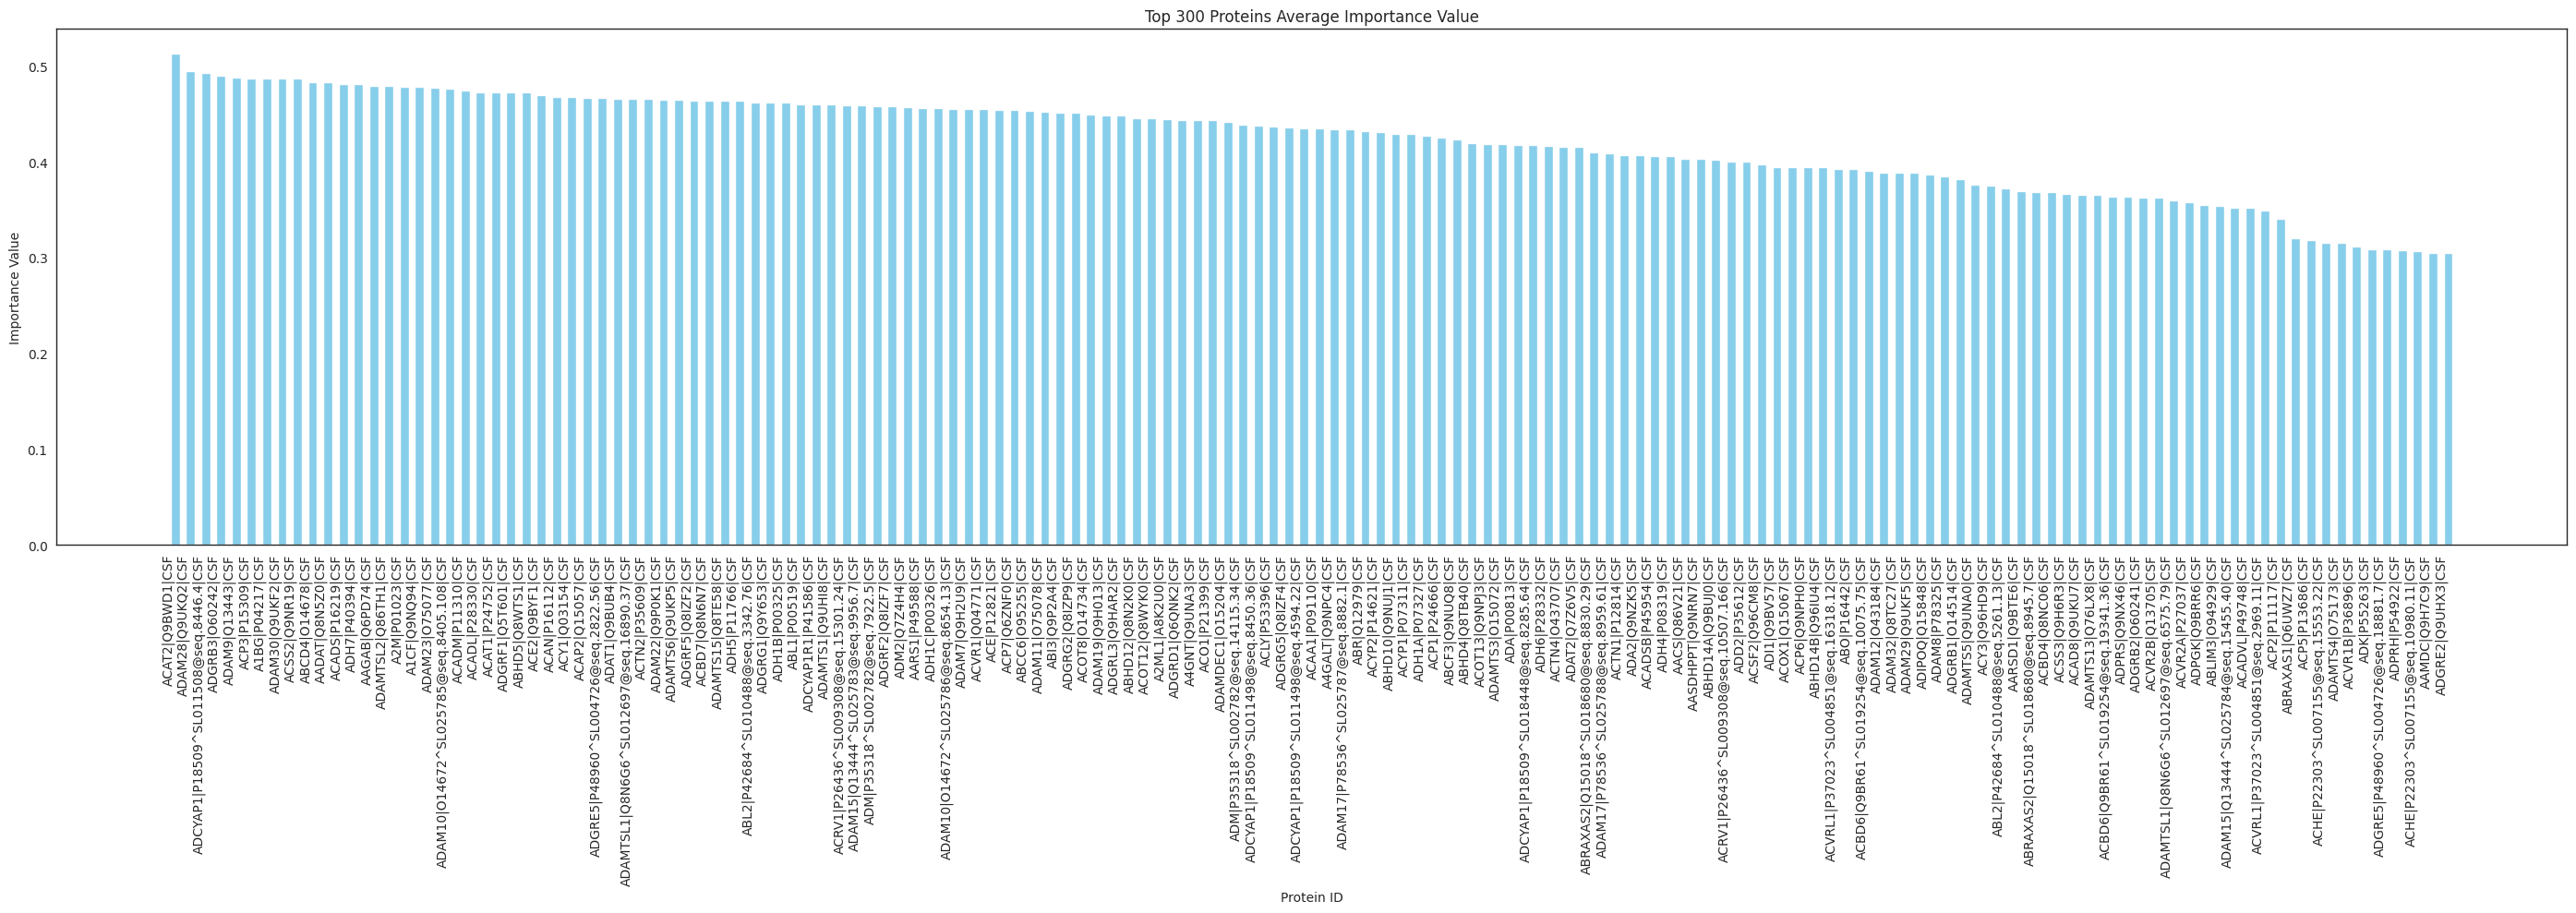

In [50]:
def divide_dict_values(dict1, dict2):
    result = {}
    for key in dict1:
        if key in dict2:
            if dict1[key] != 0:  # Avoid division by zero
                result[key] = dict2[key] / dict1[key]
            else:
                result[key] = None  # or handle division by zero as needed
    return result

sum_node_importance_avg = divide_dict_values(protein_count, sum_node_importance)

sorted_items = sorted(sum_node_importance_avg.items(), key=lambda x: x[1], reverse=True)
# Get the first 300 items (or less if there are fewer than 300 items)
top_300_items = sorted_items[:200]


def plot_a_dictionary(dict, title, x_label, y_label):
    # Separate the items into x and y components for plotting
    keys = [item[0] for item in dict]
    values = [item[1] for item in dict] # Value is a list of one object

    # Plot the data
    plt.figure(figsize=(28, 10))
    bar_width = 0.6
    plt.bar(keys, values, color='skyblue', width=bar_width)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=90, ha='right')  # Rotate x-ticks for better readability
    plt.tight_layout()  # Adjust layout to ensure everything fits without overlapping
    #plt.gca().invert_xaxis()  # Invert y-axis to have the highest values on top
    plt.show()


plot_a_dictionary(top_300_items, 'Top 300 Proteins Average Importance Value', 'Protein ID', 'Importance Value')


Plot counts per protein

<class 'collections.Counter'>


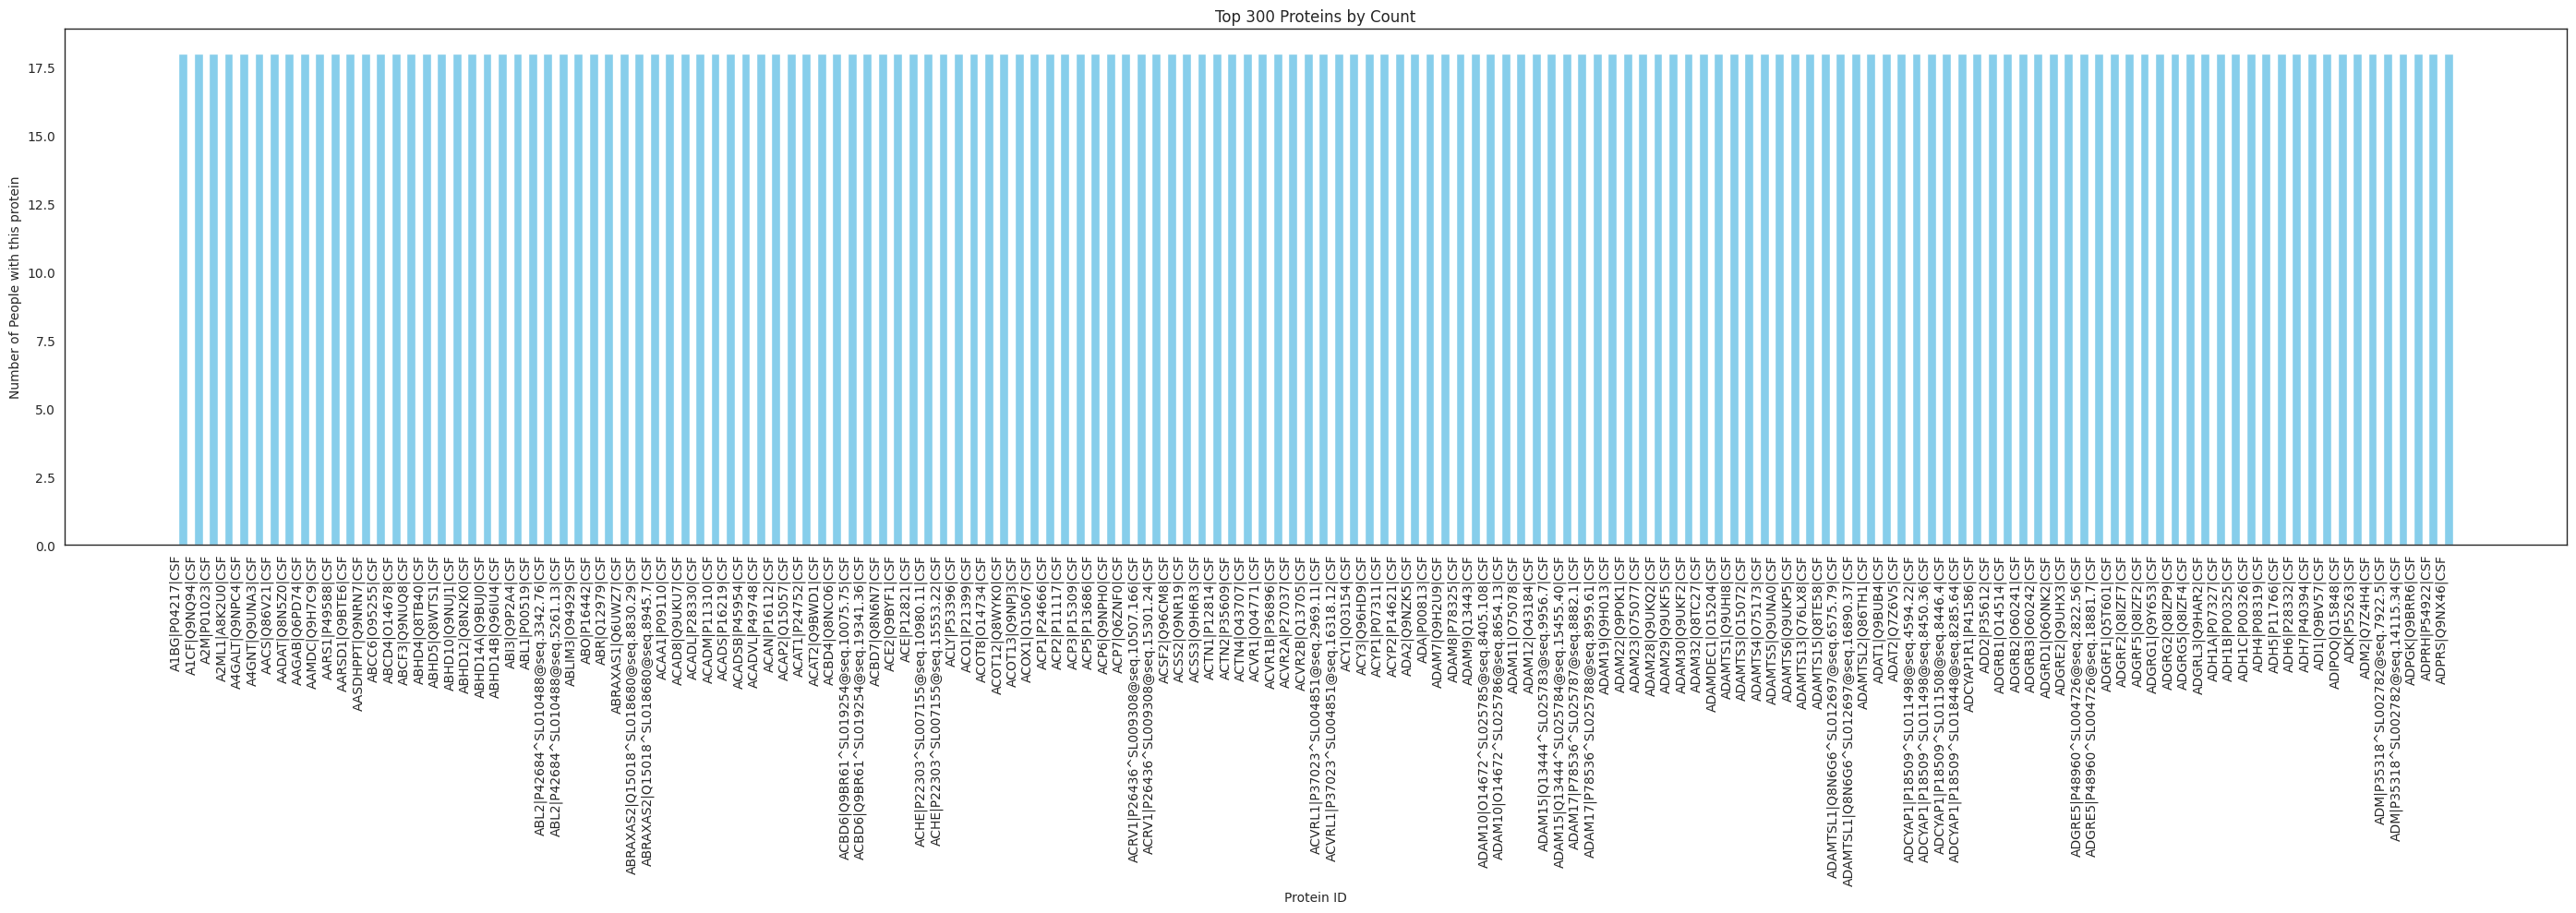

In [51]:
import matplotlib.pyplot as plt

print(type(protein_count))
sorted_proteins = sorted(protein_count.items(), key=lambda x: x[1], reverse=True)

top_300_count = sorted_proteins[:1000]

plot_a_dictionary(top_300_count, 'Top 300 Proteins by Count', 'Protein ID', 'Number of People with this protein')

Find WGCNA Clusters

(441, 7289)
Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  6137
    Power  SFT.R.sq     slope truncated R.sq     mean(k)   median(k)  \
0       1  0.628611 -0.930622       0.774962  586.547051  374.357936   
1       2   0.73949 -0.839783       0.956489  239.773855   71.531197   
2       3  0.817364 -0.799865       0.968549  139.649918   17.753762   
3       4  0.874339 -0.782453       0.968892   94.265611    5.458057   
4       5  0.908199 -0.784746        0.95725   68.560268    1.997544   
5       6   0.92714 -0.802024       0.944771   52.161658    0.843222   
6       7  0.942585  -0.82067       0.943414   40.920431    0.378143   
7       8  0.938895 -0.843951        0.92422   32.833747    0.183264   
8       9   0.93418 -0.863399       0.915385     26.8097    0.089957   
9      10  0.922563 -0.885622       0.903574   22.200989     0.04667   
10     11  0.907874 -0.912621       0.894529    18.59975     0.02322   
11     13  0.873799 -

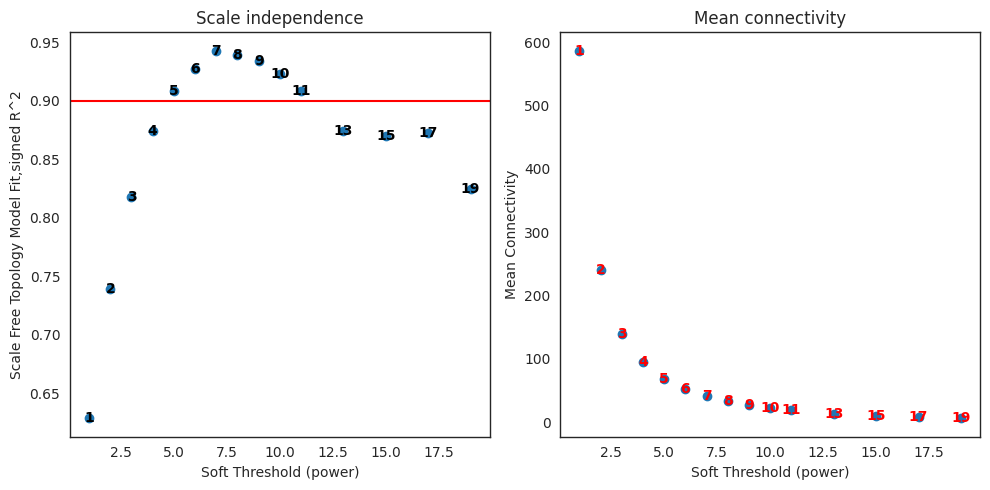

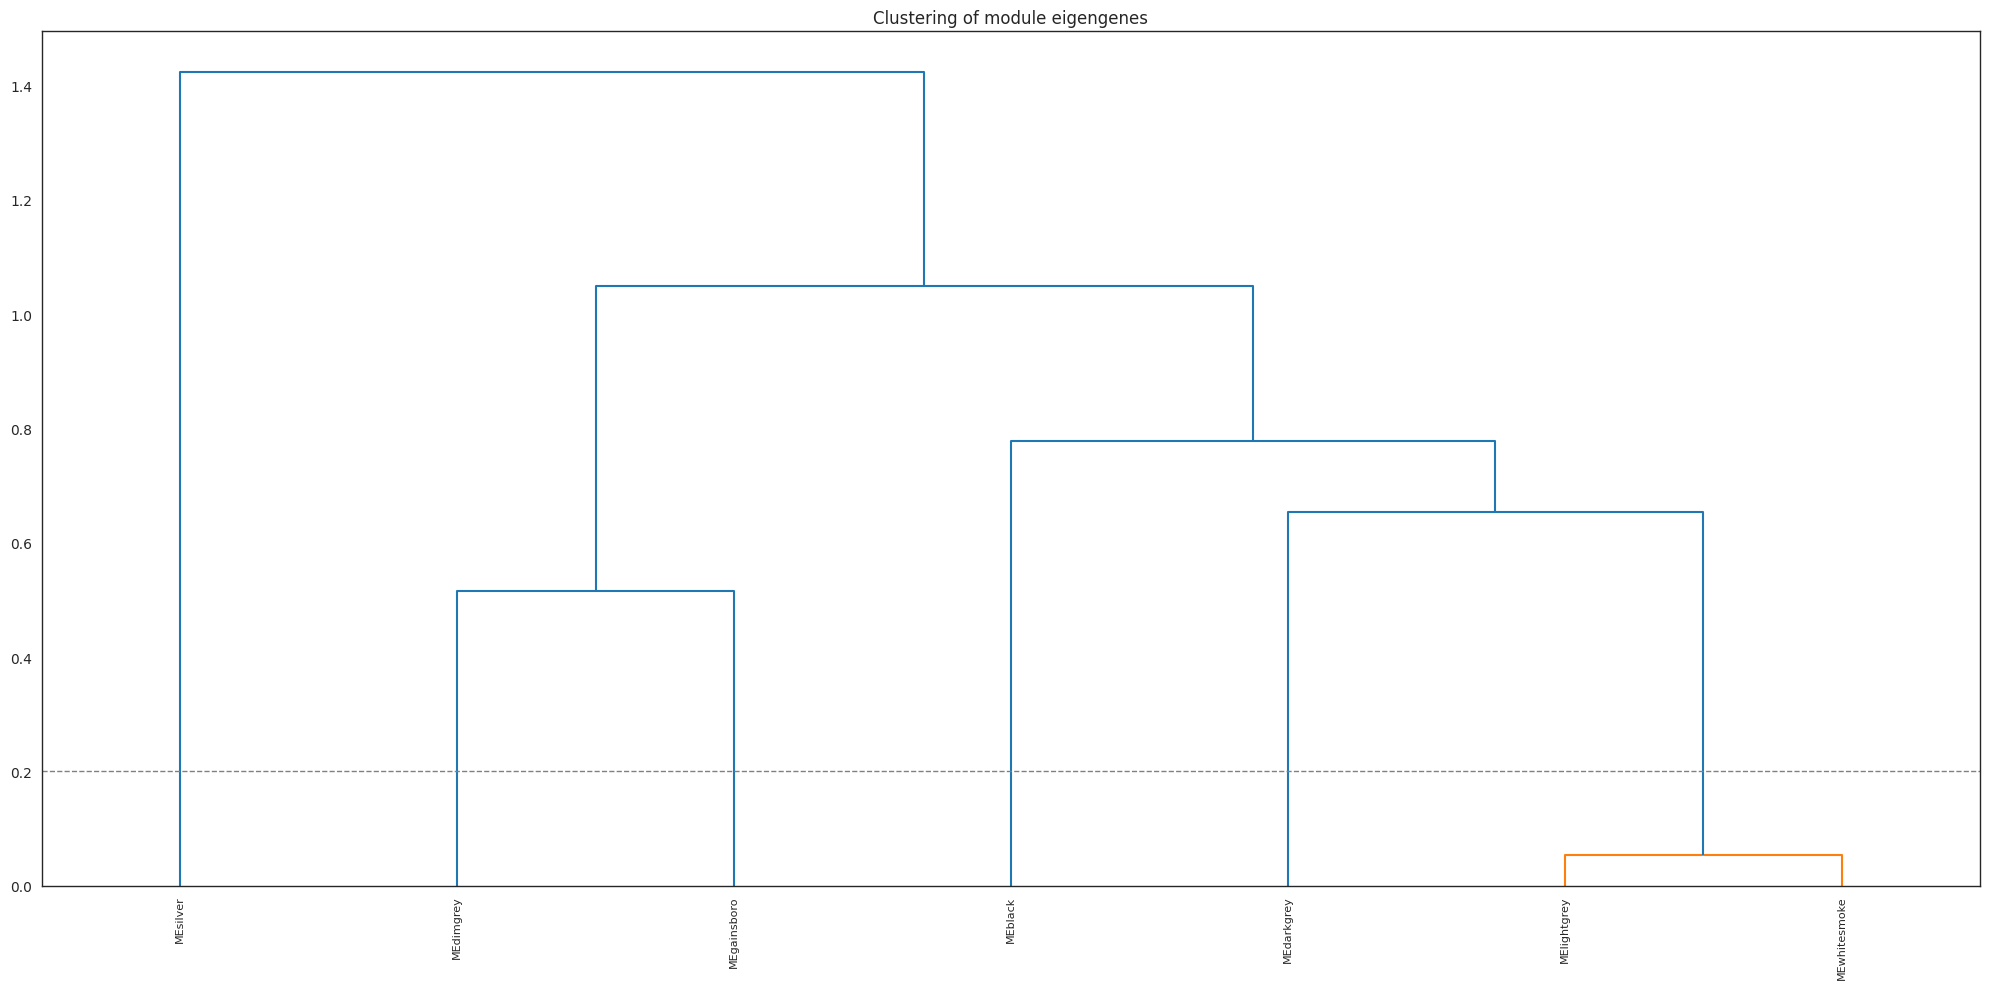

In [10]:
import pandas as pd
import PyWGCNA
from PyWGCNA import WGCNA

# Step 1: Load your data
# Assuming you have a CSV file with rows as proteins and columns as samples
csv_data = pd.read_csv(CSV_PATH)
has_plasma = csv_data.iloc[:, 9].astype(int)
has_plasma = has_plasma == 1  # Converting from indices to boolean
nfl = csv_data.loc[has_plasma, csv_data.columns[8]].astype(float)
nfl_mask = ~np.isnan(nfl)
# Extract the protein column names
plasma_protein_cols = csv_data.columns[10 : 7299]
    
# Extract and convert the plasma_protein values for rows where has_plasma is True and nfl is not NaN
plasma_protein = csv_data.loc[has_plasma, plasma_protein_cols][nfl_mask].astype(float)
print(plasma_protein.shape)

# Step 2: Initialize WGCNA object
plasma_wgcna = WGCNA(name = "FTD_Dataset", species = "Human", geneExp= plasma_protein)

plasma_wgcna.findModules()

# Constructing dict of module names and the proteins in each module
plasma_module_names = plasma_wgcna.getModuleName()
plasma_module_dict = {}
for module in plasma_module_names:
    plasma_module_proteins = plasma_wgcna.getGeneModule(module)
    plasma_module_dict[module] = plasma_module_proteins



(224, 7288)
Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  6138
    Power  SFT.R.sq     slope truncated R.sq     mean(k)   median(k)  \
0       1  0.004038  0.071973       0.881355  934.083829  901.227021   
1       2  0.538619  -0.80742       0.925584  367.384129  318.411073   
2       3   0.78235 -1.198074       0.942724  181.165253  136.209151   
3       4  0.838143 -1.352645       0.945244  102.107911   66.172565   
4       5  0.872661 -1.411326       0.952143   62.874064   34.650979   
5       6  0.886721 -1.458709       0.953695    41.23899   19.206595   
6       7  0.909383 -1.466844        0.96753    28.36449   11.229217   
7       8  0.928432 -1.456184       0.976254   20.247527    6.749982   
8       9  0.937819 -1.456217       0.979081   14.892034    4.141742   
9      10  0.947579 -1.450844       0.983046   11.226136    2.578914   
10     11  0.960514 -1.434878       0.987211     8.63928    1.649926   
11     13  0.931474 -

TypeError: WGCNA.moduleEigengenes() missing 1 required positional argument: 'colors'

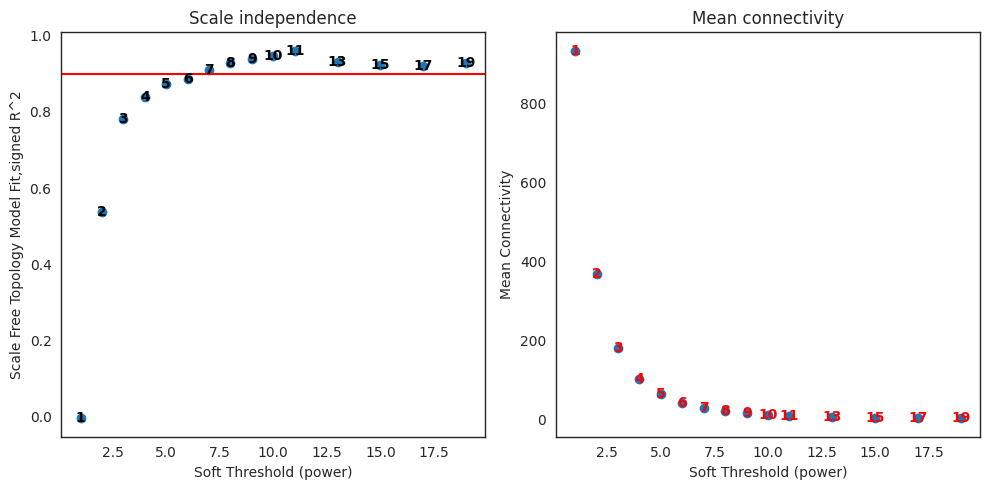

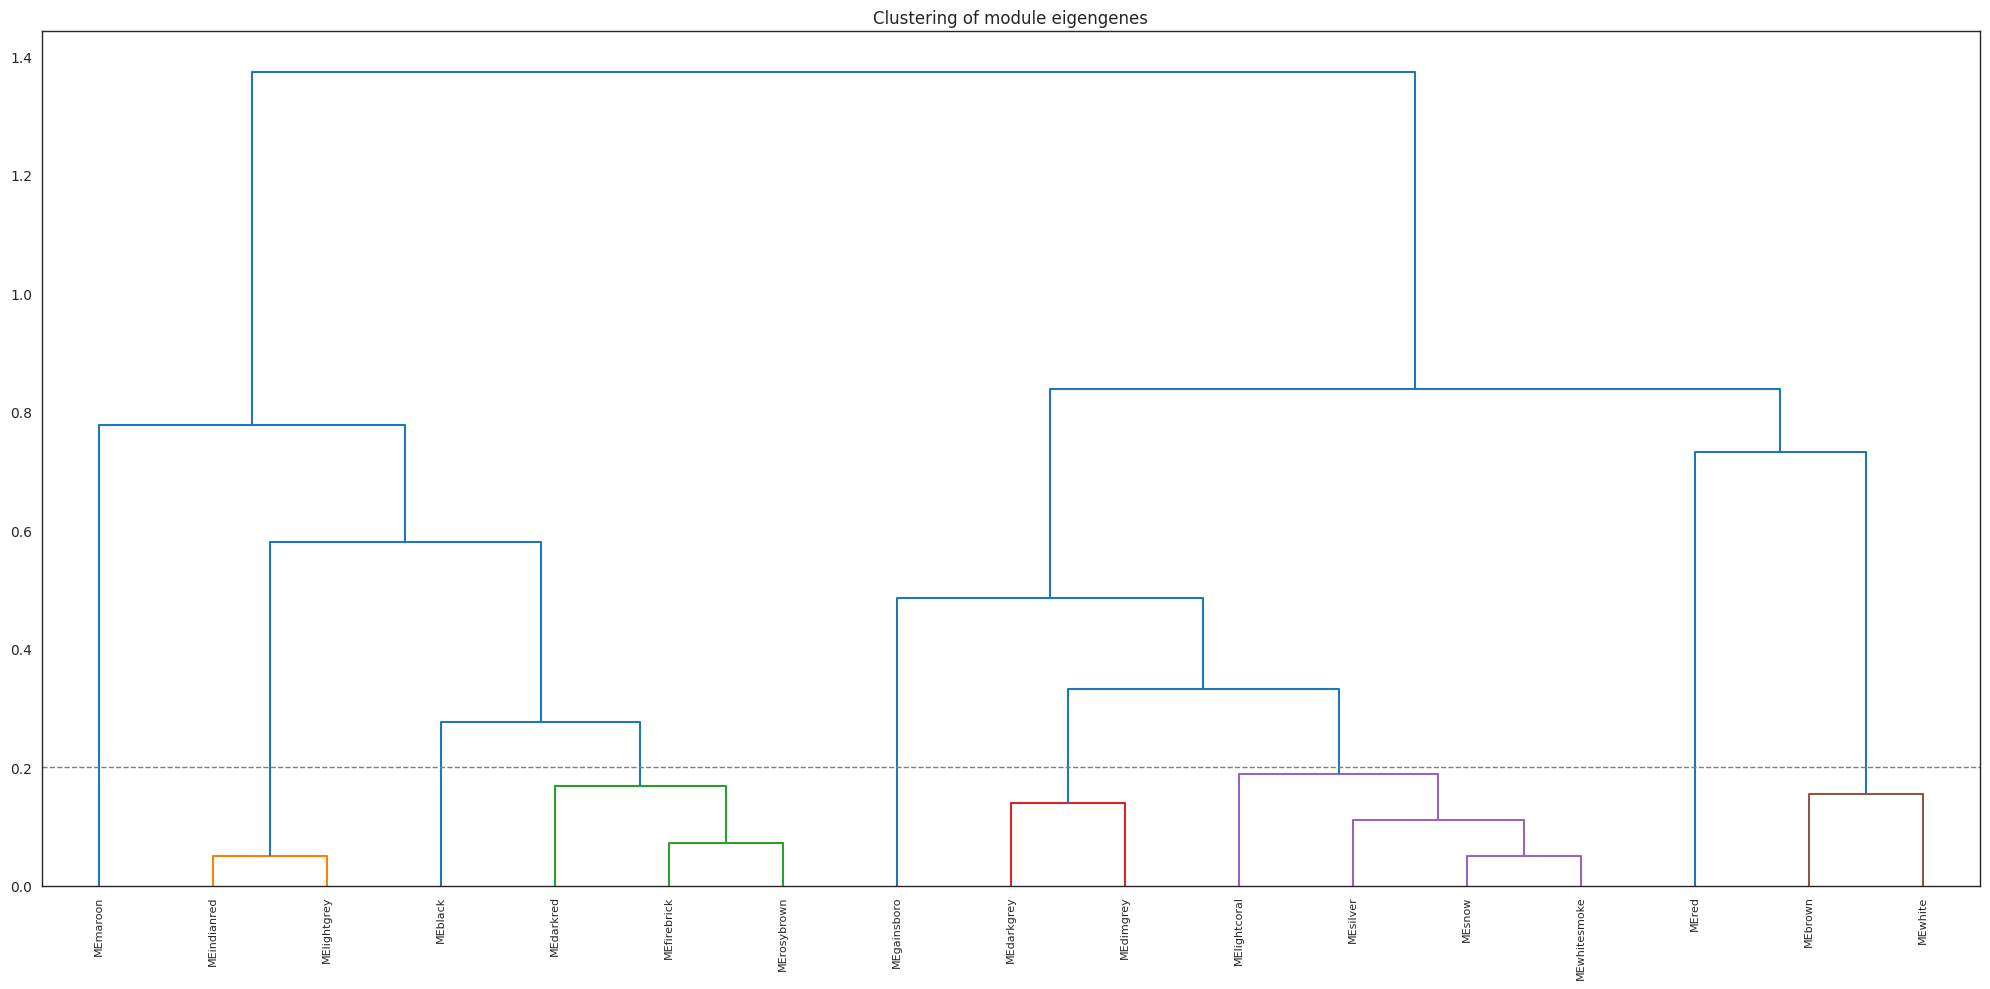

In [9]:
import pandas as pd
import PyWGCNA
from PyWGCNA import WGCNA

# Same as above but with CSF proteins
# Step 1: Load your data
# Assuming you have a CSV file with rows as proteins and columns as samples
csv_data = pd.read_csv(CSV_PATH)
has_csf = csv_data.iloc[:, 7299].astype(int)
has_csf = has_csf == 1  # Converting from indices to boolean
nfl = csv_data.loc[has_csf, csv_data.columns[8]].astype(float)
nfl_mask = ~np.isnan(nfl)
# Extract the protein column names
csf_protein_cols = csv_data.columns[7300 : 14588]
    
# Extract and convert the plasma_protein values for rows where has_plasma is True and nfl is not NaN
csf_protein = csv_data.loc[has_csf, csf_protein_cols][nfl_mask].astype(float)
print(csf_protein.shape)

# Step 2: Initialize WGCNA object
csf_wgcna = WGCNA(name = "FTD_Dataset", species = "Human", geneExp= csf_protein)

csf_wgcna.findModules()

# Constructing dict of module names and the proteins in each module
csf_module_names = csf_wgcna.getModuleName()
csf_module_dict = {}
for module in csf_module_names:
    csf_module_proteins = csf_wgcna.getGeneModule(module)
    csf_module_dict[module] = csf_module_proteins



Plot counts per WGCNA Cluster

In [10]:
# Constructing dict of module names and the proteins in each module
wgcna_modules_dict= {}

for module in csf_module_dict:
    wgcna_modules_dict[module] = csf_module_dict[module][module].index

# Step 1: Aggregate the counts for each module
module_counts = {}

# Iterate over the wgcna_module_dict correctly using the Index object
for module, proteins in wgcna_modules_dict.items():  # 'proteins' is actually an Index object
    total_count = 0
    for protein in proteins:  # Iterate directly over the Index object
        if protein in protein_count:
            total_count += protein_count[protein]
    module_counts[module] = total_count


# Sanity check to make sure all proteins were counted
total_count_protein = sum(protein_count.values())
print("Total count protein:", total_count_protein)
total_count_modules = sum(module_counts.values())
print("Total count module:", total_count_modules)



# Step 2: Plot the aggregated counts
module_names = list(module_counts.keys())
total_counts = list(module_counts.values())
colors = []
for key,value in module_counts.items():
    colors.append([key]*value)

print(csf_wgcna.moduleEigengenes(csf_protein, colors))

plt.figure(figsize=(10, 6))
plt.bar(module_names, total_counts, color='skyblue')
plt.xlabel('Modules')
plt.ylabel('Total Counts')
plt.title('Total Counts for Each Module')
plt.show()



NameError: name 'protein_count' is not defined

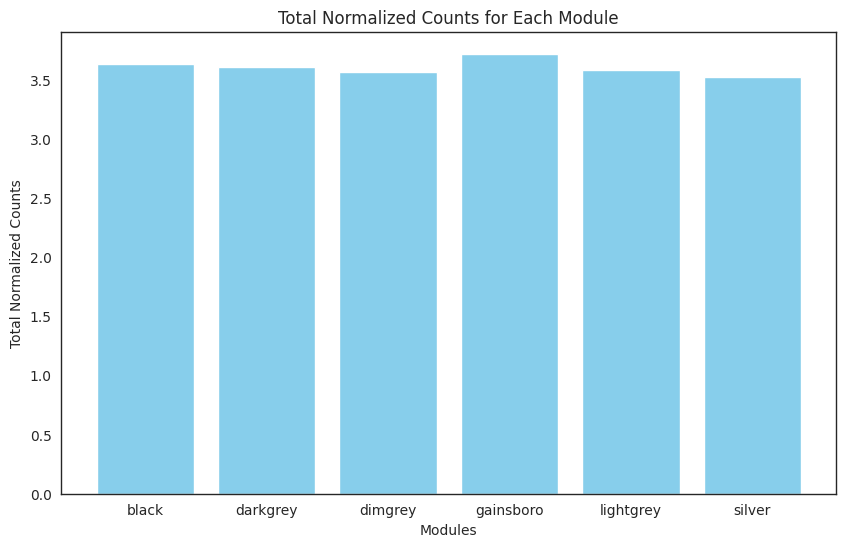

In [12]:
# Normalize by WGCNA module size
protein_counts_per_module = {}

# Iterate over each module in module_dict
for module, proteins in wgcna_modules_dict.items():
    protein_counts_per_module[module] = len(proteins)


normalized_module_counts = divide_dict_values(protein_counts_per_module, module_counts)

# Step 2: Plot the aggregated counts
module_names = list(normalized_module_counts.keys())
total_normalized_counts = list(normalized_module_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(module_names, total_normalized_counts, color='skyblue')
plt.xlabel('Modules')
plt.ylabel('Total Normalized Counts')
plt.title('Total Normalized Counts for Each Module')
plt.show()

Plot average importance per WGCNA cluster

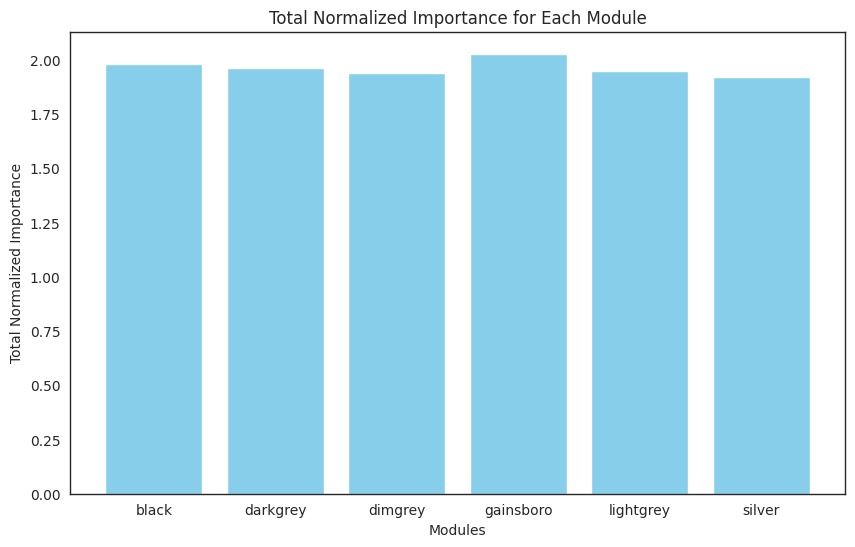

In [13]:
# Step 1: Aggregate the counts for each module
module_importance = {}

# Iterate over the wgcna_module_dict correctly using the Index object
for module, proteins in wgcna_modules_dict.items():  # 'proteins' is actually an Index object
    total_importance = 0
    for protein in proteins:  # Iterate directly over the Index object
        if protein in sum_node_importance:
            total_importance += sum_node_importance[protein]
    module_importance[module] = total_importance

# Normalize by WGCNA module size to get average importance
normalized_module_importance = divide_dict_values(protein_counts_per_module, module_importance)

# Step 2: Plot the aggregated counts
module_names = list(normalized_module_importance.keys())
total_normalized_importance = list(normalized_module_importance.values())

plt.figure(figsize=(10, 6))
plt.bar(module_names, total_normalized_importance, color='skyblue')
plt.xlabel('Modules')
plt.ylabel('Total Normalized Importance')
plt.title('Total Normalized Importance for Each Module')
plt.show()